### prediction of survival using pyspark in pipeline

In [ ]:
import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import StandardScaler,PCA
from pyspark.sql import DataFrame
from typing import Iterable

In [2]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,VectorAssembler
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,NaiveBayes,RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [3]:
#creating spark environment
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [4]:
#libraries for creating machine learning pipeline
from pyspark.ml import Pipeline
from pyspark.ml import Transformer

In [5]:
#creating sparkcontext and spark variables
sc=SparkContext()
spark=SparkSession.builder.master("local[1]").appName("titan").getOrCreate()

In [6]:
#importing training dataset
df_tr=spark.read.option("header",True).option("inferSchema",True).csv("c:/csv-ml/titanic_train.csv")

In [7]:
#importing test dataset
df_test=spark.read.option("header",True).option("inferSchema",True).csv("c:/csv-ml/titanic_test.csv")

In [8]:
#displaying traing dataset
df_tr.show(5)

+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|survived|pclass|                name|   sex| age|sibsp|parch|          ticket|   fare|cabin|embarked|
+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 5 rows



In [9]:
#checking missing values in pandas
df_tr_pd=df_tr.toPandas()
df_test_pd=df_test.toPandas()
df_tr_pd.isna().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [10]:
df_test_pd.isna().sum()

pclass        0
name          0
sex           0
age          86
sibsp         0
parch         0
ticket        0
fare          1
cabin       327
embarked      0
dtype: int64

In [11]:
df_tr_pd.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [12]:
#checking datatypes
df_tr_pd.dtypes

survived      int32
pclass        int32
name         object
sex          object
age         float64
sibsp         int32
parch         int32
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

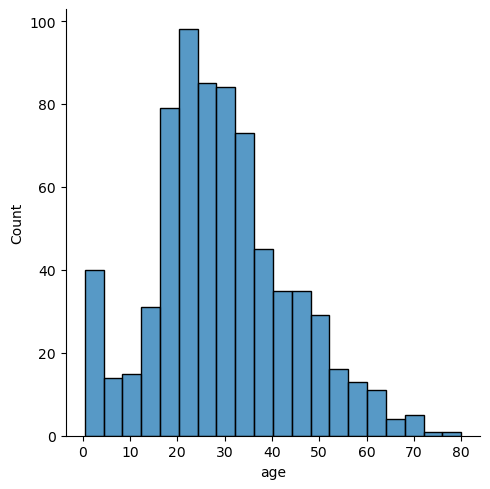

In [13]:
#univariate analysis of the columns with missing values
#almost normal distribution so can be replaced with mean
sns.displot(df_tr_pd["age"])


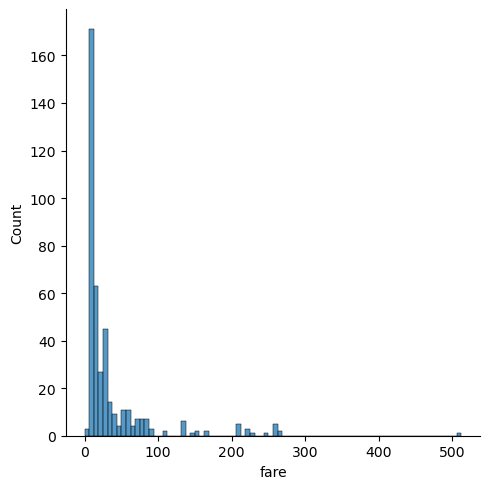

In [14]:
#highly right skewed data to be replaced with median
sns.displot(df_test_pd["fare"])

In [15]:
#ouliers are present
df_test_pd["fare"].kurtosis()

17.92159525773599

In [16]:
df_tr_pd["age"].skew()

0.38910778230082704

In [17]:
df_test_pd["fare"].skew()

3.6872133081121405

In [18]:
#embarked column is categorical to be replaced with mode
df_tr_pd["embarked"].mode()[0]

'S'

In [19]:
df_tr_pd["embarked"].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [20]:
#creating column transformer to drop specific columns in pipeline
class ColumnDropper(Transformer):
    """
    A custom Transformer which drops all columns 
    """

    def __init__(self, banned_list):
       
        self.banned_list = banned_list

    def _transform(self, df: DataFrame) -> DataFrame:
        for i in self.banned_list:
            df=df.drop(i)
       
        return df


In [21]:
#creating column transformer to fill missing values with mean
class Columnfiller_mean(Transformer):
    """
    A custom Transformer which drops all columns 
    """

    def __init__(self,col):
       
        self.col = col

    def _transform(self, df: DataFrame) -> DataFrame:
        m=df.agg({self.col:"avg"}).collect()[0][0]
        df=df.fillna(value=m,subset=[self.col])       
        return df

In [22]:
#creating column transformer to fill missing values with median
class Columnfiller_median(Transformer):
    """
    A custom Transformer which drops all columns 
    """

    def __init__(self,col):
       
        self.col = col

    def _transform(self, df: DataFrame) -> DataFrame:
        q=df_tr.approxQuantile("fare", [0.5], 0.0)
        str_quant="".join(str(q[0]))
      
        quant=float(str_quant)
        df=df.fillna(value=quant,subset=[self.col])       
        return df

In [23]:
#creating column transformer to fill missing values with mode
class Columnfiller_mode(Transformer):
    """
    A custom Transformer which drops all columns 
    """

    def __init__(self,col):
       
        self.col = col

    def _transform(self, df: DataFrame) -> DataFrame:
        m=df.agg({self.col:"max"}).collect()[0][0]
        df=df.fillna(value=m,subset=[self.col])        
        return df

In [24]:
#creating stages of cleaning pipeline
stage1_clean=ColumnDropper(banned_list = ["cabin","ticket","name"])
stage2_clean=Columnfiller_mean("age")
stage3_clean=Columnfiller_median("fare")
stage4_clean=Columnfiller_mode("embarked")

In [25]:
pipeline_clean=Pipeline(stages=[stage1_clean,stage2_clean,stage3_clean,stage4_clean])

In [26]:
#fit and transform with the pipeline
df_clean=pipeline_clean.fit(df_tr).transform(df_tr)

In [27]:
#creating stages of encoding pipeline(StringIndexer,OneHotEnder,VectorAssembler)
stage1_encode=StringIndexer(inputCols=['sex','embarked'],outputCols=['sex_idx','embarked_idx'])
stage2_encode=OneHotEncoder(inputCols=['sex_idx','embarked_idx'],outputCols=['sex_ohe','embarked_ohe'])
stage3_encode=VectorAssembler(inputCols=['pclass',  'sex_ohe', 'age', 'sibsp', 'parch', 'fare', 'embarked_ohe'],outputCol="features")

In [28]:
pipeline_encode=Pipeline(stages=[stage1_encode,stage2_encode,stage3_encode])

In [29]:
#fit and transform with encoding pipeleine
df_final=pipeline_encode.fit(df_clean).transform(df_clean)

In [30]:
#performing the cleaning operations with the test dataset as well
df_clean_test=pipeline_clean.fit(df_test).transform(df_test)

In [31]:
df_final_test=pipeline_encode.fit(df_clean_test).transform(df_clean_test)

In [32]:
df_final.show(10)

+--------+------+------+-----------------+-----+-----+-------+--------+-------+------------+-------------+-------------+--------------------+
|survived|pclass|   sex|              age|sibsp|parch|   fare|embarked|sex_idx|embarked_idx|      sex_ohe| embarked_ohe|            features|
+--------+------+------+-----------------+-----+-----+-------+--------+-------+------------+-------------+-------------+--------------------+
|       0|     3|  male|             22.0|    1|    0|   7.25|       S|    0.0|         0.0|(1,[0],[1.0])|(2,[0],[1.0])|[3.0,1.0,22.0,1.0...|
|       1|     1|female|             38.0|    1|    0|71.2833|       C|    1.0|         1.0|    (1,[],[])|(2,[1],[1.0])|[1.0,0.0,38.0,1.0...|
|       1|     3|female|             26.0|    0|    0|  7.925|       S|    1.0|         0.0|    (1,[],[])|(2,[0],[1.0])|(8,[0,2,5,6],[3.0...|
|       1|     1|female|             35.0|    1|    0|   53.1|       S|    1.0|         0.0|    (1,[],[])|(2,[0],[1.0])|[1.0,0.0,35.0,1.0...|
|     

In [33]:
#selecting only the feature vector and target variable
df_final2=df_final.select("features","survived")

In [34]:
df_final2.show(10)

+--------------------+--------+
|            features|survived|
+--------------------+--------+
|[3.0,1.0,22.0,1.0...|       0|
|[1.0,0.0,38.0,1.0...|       1|
|(8,[0,2,5,6],[3.0...|       1|
|[1.0,0.0,35.0,1.0...|       1|
|[3.0,1.0,35.0,0.0...|       0|
|(8,[0,1,2,5],[3.0...|       0|
|[1.0,1.0,54.0,0.0...|       0|
|[3.0,1.0,2.0,3.0,...|       0|
|[3.0,0.0,27.0,0.0...|       1|
|[2.0,0.0,14.0,1.0...|       1|
+--------------------+--------+
only showing top 10 rows



In [35]:
#renaming the target variable to label for evaluation
df_final2=df_final2.withColumnRenamed("survived","label")

In [36]:
#split the data into train test
tr,test=df_final2.randomSplit([.75,.25],seed=100)

In [37]:
#creating 3 types of model pipeline
logit_pipeline=Pipeline(stages=[StandardScaler(inputCol="features",outputCol="features_scaled"),LogisticRegression(featuresCol="features_scaled",labelCol="label")])
naive_pipeline=Pipeline(stages=[StandardScaler(inputCol="features",outputCol="features_scaled"),NaiveBayes(featuresCol="features_scaled",labelCol="label")])
dtree_pipeline=Pipeline(stages=[StandardScaler(inputCol="features",outputCol="features_scaled"),DecisionTreeClassifier(featuresCol="features_scaled",labelCol="label")])


In [38]:
#adding 3 types of classification model pipeline instances in a list
model_pipeline=[logit_pipeline,naive_pipeline,dtree_pipeline]

In [39]:
#creating an instance of binary evaluator
eval1=BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="prediction",metricName="areaUnderROC")

In [40]:
#fitting the model and evaluation
model_fit=[]
eval_mod=[]
for i in model_pipeline:
    j=i.fit(tr).transform(tr)
    eval_mod.append(eval1.evaluate(j))
    model_fit.append(j)


In [41]:
#creating a dataframe for viewiung training score
df_model_tr=pd.DataFrame({"model":["logistic","naive_bayes","decision tree"],"roc_score_train":eval_mod})
    

In [42]:
df_model_tr

,model,roc_score_train
0,logistic,0.789169
1,naive_bayes,0.684833
2,decision tree,0.837700


In [43]:
#prediction with the validation dataset 
model_fit_test=[]
eval_mod_test=[]
for i in model_pipeline:
    j=i.fit(tr).transform(test) #fitting with train ,prediction with test
    eval_mod_test.append(eval1.evaluate(j))
    model_fit_test.append(j)


In [44]:
df_model_test=pd.DataFrame({"model":["logistic","naive_bayes","decision tree"],"roc_score_test":eval_mod_test})
    

In [45]:
#dataframe to display test score
df_model_test

,model,roc_score_test
0,logistic,0.779561
1,naive_bayes,0.682000
2,decision tree,0.716488


In [46]:
#prediction with actual test dataset with no target variable
df_final_test2=df_final_test.select("features")

In [47]:
df_test2=logit_pipeline.fit(df_final2).transform(df_final_test2)

In [49]:
df_test2.show()

+--------------------+--------------------+--------------------+--------------------+----------+
|            features|     features_scaled|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|(8,[0,1,2,5],[3.0...|(8,[0,1,2,5],[3.5...|[2.13290799369150...|[0.89406075799583...|       0.0|
|[3.0,0.0,47.0,1.0...|[3.58821097170396...|[0.61119899329456...|[0.64821426012167...|       0.0|
|(8,[0,1,2,5],[2.0...|(8,[0,1,2,5],[2.3...|[2.11774139220002...|[0.89261562715057...|       0.0|
|[3.0,1.0,27.0,0.0...|[3.58821097170396...|[2.21501727133546...|[0.90158998447085...|       0.0|
|[3.0,0.0,22.0,1.0...|[3.58821097170396...|[-0.2961177868425...|[0.42650679562305...|       1.0|
|[3.0,1.0,14.0,0.0...|[3.58821097170396...|[1.69831966847188...|[0.84531514651789...|       0.0|
|(8,[0,2,5],[3.0,3...|(8,[0,2,5],[3.588...|[-0.7723877161417...|[0.31596282179212...|       1.0|
|[2.0,1.0,26.0,1.0...|[2.39214

In [54]:
#add this prediction to the test dataframe
df_test_pd=df_test.toPandas()
df_test2_pd=df_test2.toPandas()

In [55]:
df_test_pd["pred_survived"]=df_test2_pd["prediction"]

In [56]:
df_test_pd.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,pred_survived
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q,0.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S,0.0
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q,0.0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,S,0.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,S,1.0
